In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


## Pre-processing Data

In [214]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')

# out_prncp와 완전 동일함, funded_amnt_inv는 funded_amnt와 유의미한 차이를 못발견함
df=df.drop(['out_prncp_inv', 'funded_amnt_inv', 'acc_now_delinq'], axis=1)
df['my_multiple'] = df['int_rate']*df['dti']
df['my_multiple2'] = np.log(df['annual_inc']*df['fico_range_low'])
df['my_multiple4'] = df['int_rate']*df['funded_amnt']
df['my_multiple5'] = df['int_rate']*df['dti']/np.log(df['tot_cur_bal']*df['fico_range_low'])
df['my_multiple6'] = df['revol_util']/(df['revol_bal']+0.0000001)
df['my_multiple7'] = df['int_rate']*df['funded_amnt']/np.log(df['tot_cur_bal']*df['fico_range_low']+2)
df['my_multiple9'] = np.log(df['int_rate']*df['funded_amnt'])*df['dti']
df['my_multiple11'] = df['installment']/ df['annual_inc']
# df.loc[df['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0   # 0번 추심 발생횟수
# df.loc[df['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1   # 1번 이상 추심 발생횟수
# df['my_clf2'] = df.groupby([df.term1, df.emp_length12, df.home_ownership6, df.verification_status3, df.initial_list_status1, df.collections_12_mths_ex_med, df.initial_list_status2])['depvar'].transform('mean')

In [215]:
X = df.drop('depvar', axis=1)
y = df['depvar']

# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

## 정규화

In [ ]:
# 정규화 // 오히려 정규화하고 점수 더 안좋아지는 경향

X_train_sc = StandardScaler().fit_transform(X_train)
X_valid_sc = StandardScaler().fit_transform(X_valid)

## 사용할 함수 정의

In [76]:
# Data 증축 전, 결과 값 비율
print("Before OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))

Before OverSampling, counts of label '0': 53882
Before OverSampling, counts of label '1': 26118


In [216]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [179]:
lgbm_clf = LGBMClassifier(max_depth=10, n_estimators=200, random_state=42, learning_rate=0.1, objective ='binary')
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(max_depth=10, n_estimators=200, objective='binary',
               random_state=42)


정확도: 0.7240
정밀도: 0.5523
재현율: 0.7622
AUC: 0.7340
F1: 0.6405


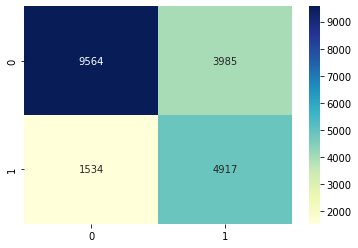

In [181]:
get_clf_eval(y_valid, lgbm_clf.predict_proba(X_valid)[:,1]>0.3)

In [173]:
rnd_clf = RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=200, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8,
                       n_estimators=200, random_state=42)


정확도: 0.6740
정밀도: 0.4963
재현율: 0.7149
AUC: 0.6847
F1: 0.5859


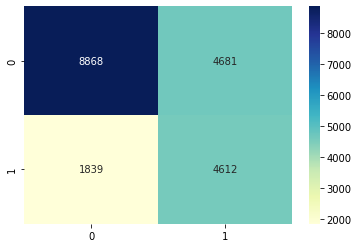

In [183]:
get_clf_eval(y_valid, rnd_clf.predict_proba(X_valid)[:,1]>0.32)

In [186]:
xgb_clf = XGBClassifier(max_depth=10, n_estimators=250, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', max_depth=10, n_estimators=250,
              random_state=42)


정확도: 0.7232
정밀도: 0.5520
재현율: 0.7532
AUC: 0.7311
F1: 0.6371


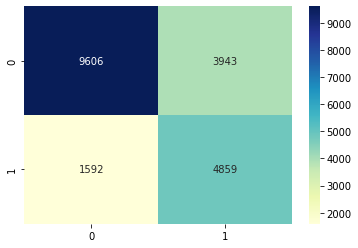

In [187]:
get_clf_eval(y_valid, xgb_clf.predict_proba(X_valid)[:,1]>0.3)

In [209]:
ext_clf = ExtraTreesClassifier(n_estimators = 200, min_samples_leaf=3, min_samples_split=4, random_state=42)
ext_clf.fit(X_train, y_train)

ExtraTreesClassifier(min_samples_leaf=3, min_samples_split=4, n_estimators=200)


정확도: 0.6486
정밀도: 0.4706
재현율: 0.7169
AUC: 0.6665
F1: 0.5683


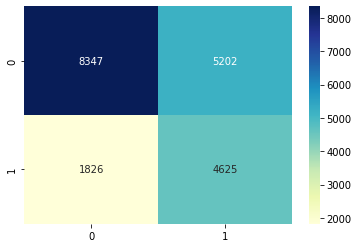

In [211]:
get_clf_eval(y_valid, ext_clf.predict_proba(X_valid)[:,1]>0.32)

## 하이퍼 파라미터 최적화

In [217]:
# 최적화 한걸로 ensemble 진행
rnd_clf = RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=150, random_state=42)
lgbm_clf = LGBMClassifier(max_depth=10, n_estimators=200, random_state=42)
xgb_clf = xgboost.XGBClassifier(max_depth=10, n_estimators=250, eval_metric='logloss', random_state=42) # 최적값 구한것
ext_clf = ExtraTreesClassifier(n_estimators = 200, min_samples_leaf=3, min_samples_split=4, random_state=42)

stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('ext', ext_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rnd',
                                RandomForestClassifier(max_depth=12,
                                                       min_samples_leaf=8,
                                                       min_samples_split=8,
                                                       n_estimators=150,
                                                       random_state=42)),
                               ('ext',
                                ExtraTreesClassifier(min_samples_leaf=3,
                                                     min_samples_split=4,
                                                     n_estimators=200,
                                                     random_state=42)),
                               ('lgbm',
                                LGBMClassifier(max_depth=10, n_estimators=200,
                                               random_state=42)),
                               ('xgb',
                                XGBClassi


정확도: 0.7208
정밀도: 0.5469
재현율: 0.7850
AUC: 0.7377
F1: 0.6446


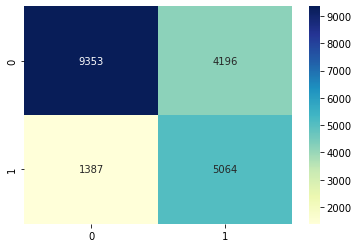

In [221]:
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.30)     # 0.6439 -> 0.6405
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.35)  #0.6403 -> 0.6376
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.32)   #0.6401 ->n_esti증가 & max_depth증가-> 6372

In [223]:
# 제출 양식 다운로드
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/competition_1st/sample_submission.csv')
df_test = df_test.drop(['out_prncp_inv', 'funded_amnt_inv', 'acc_now_delinq'], axis=1)

# test파일에도 위에서 했던 전처리 진행
df_test['my_multiple'] = df_test['int_rate']*df_test['dti']
df_test['my_multiple2'] = np.log(df_test['annual_inc']*df_test['fico_range_low'])
df_test['my_multiple4'] = df_test['int_rate']*df_test['funded_amnt']
df_test['my_multiple5'] = df_test['int_rate']*df_test['dti']/np.log(df['tot_cur_bal']*df_test['fico_range_low'])
df_test['my_multiple6'] = df_test['revol_util']/(df_test['revol_bal']+0.0000001)
df_test['my_multiple7'] = df_test['int_rate']*df_test['funded_amnt']/np.log(df_test['tot_cur_bal']*df_test['fico_range_low']+2)
df_test['my_multiple9'] = np.log(df_test['int_rate']*df_test['funded_amnt'])*df_test['dti']
df_test['my_multiple11'] = df_test['installment']/ df_test['annual_inc']
# df_test.loc[df['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0   # 0번 추심 발생횟수
# df_test.loc[df['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1   # 1번 이상 추심 발생횟수
# df_test['my_clf2'] = df.groupby([df.term1, df.emp_length12, df.home_ownership6, df.verification_status3, df.initial_list_status1, df.collections_12_mths_ex_med, df.initial_list_status2])['depvar'].transform('mean')

submit['answer'] = stacking_clf.predict_proba(df_test.drop(columns=['ID']))[:,1]>0.33
change = {True:1, False:0}
submit.answer = submit.answer.map(change)
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/competition_1st/submission_19.csv', index=False)